# Stellargraph example: Graph Attention Network (GAT) on the CORA citation dataset

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML

### Loading the CORA network

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
dataset.download()

Load the graph from edgelist (in `cited-paper` <- `citing-paper` order)

In [3]:
edgelist = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names = feature_names + ["subject"]
node_data = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.content"),
    sep="\t",
    header=None,
    names=column_names,
)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=140, test_size=None, stratify=node_data["subject"]
)
val_data, test_data = model_selection.train_test_split(
    test_data, train_size=500, test_size=None, stratify=test_data["subject"]
)

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter

Counter(train_data["subject"])

Counter({'Neural_Networks': 42,
         'Genetic_Algorithms': 22,
         'Rule_Learning': 9,
         'Case_Based': 16,
         'Probabilistic_Methods': 22,
         'Theory': 18,
         'Reinforcement_Learning': 11})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict("records"))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict("records"))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

## Creating the GAT model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [12]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [13]:
print(G.info())

NetworkXStellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [14]:
generator = FullBatchNodeGenerator(G, method="gat")

For training we map only the training nodes returned from our splitter and the target values.

In [15]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GAT layers with 8-dimensional hidden node features for the first layer and the 7 class classification output for the second layer.
 * `attn_heads` is the number of attention heads in all but the last GAT layer in the model
 * `activations` is a list of activations applied to each layer's output
 * Arguments such as `bias`, `in_dropout`, `attn_dropout` are internal parameters of the model, execute `?GAT` for details. 

To follow the GAT model architecture used for Cora dataset in the original paper [Graph Attention Networks. P. Velickovic et al. ICLR 2018 https://arxiv.org/abs/1710.10903], let's build a 2-layer GAT model, with the 2nd layer being the classifier that predicts paper subject: it thus should have the output size of `train_targets.shape[1]` (7 subjects) and a softmax activation.

In [16]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

Expose the input and output tensors of the GAT model for node prediction, via GAT.build() method:

In [17]:
x_inp, predictions = gat.build()

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [18]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [19]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

Train the model

In [21]:
history = model.fit_generator(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 0s - loss: 1.9069 - acc: 0.2000 - val_loss: 1.8187 - val_acc: 0.3540
Epoch 2/50
1/1 - 0s - loss: 1.7973 - acc: 0.3214 - val_loss: 1.7286 - val_acc: 0.3640
Epoch 3/50
1/1 - 0s - loss: 1.7595 - acc: 0.3143 - val_loss: 1.6500 - val_acc: 0.3860
Epoch 4/50
1/1 - 0s - loss: 1.6281 - acc: 0.4286 - val_loss: 1.5803 - val_acc: 0.4080
Epoch 5/50
1/1 - 0s - loss: 1.4758 - acc: 0.5000 - val_loss: 1.5141 - val_acc: 0.4520
Epoch 6/50
1/1 - 0s - loss: 1.4778 - acc: 0.4429 - val_loss: 1.4507 - val_acc: 0.5040
Epoch 7/50
1/1 - 0s - loss: 1.3761 - acc: 0.4929 - val_loss: 1.3885 - val_acc: 0.5540
Epoch 8/50
1/1 - 0s - loss: 1.3111 - acc: 0.5500 - val_loss: 1.3284 - val_acc: 0.6200
Epoch 9/50
1/1 - 0s - loss: 1.2383 - acc: 0.5929 - val_loss: 1.2704 - val_acc: 0.6760
Epoch 10/50
1/1 - 0s - loss: 1.1667 - acc: 0.6714 - val_loss: 1.2157 - val_acc: 0.7220
Epoch 11/50
1/1 - 0s - loss: 1.0948 - acc: 0.6929 - val_loss: 1.1655 - val_acc: 0.7580
Epoch 12/50
1/1 - 0s - loss: 1.0069 - acc: 0.7857 - 

Plot the training history:

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

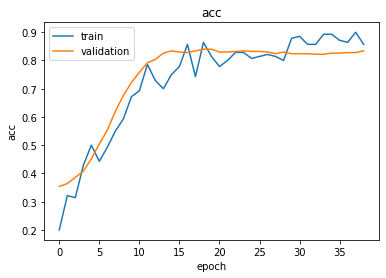

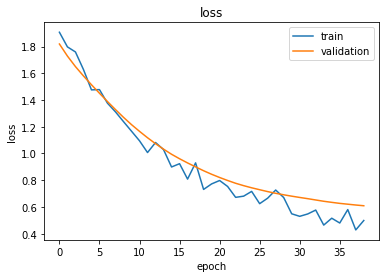

In [23]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [24]:
model.load_weights("logs/best_model.h5")

Evaluate the best model on the test set

In [25]:
test_gen = generator.flow(test_data.index, test_targets)

In [26]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.8739
	acc: 0.8312


### Making predictions with the model

Now let's get the predictions for all nodes:

In [27]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

Note that for full-batch methods the batch size is 1 and the predictions have shape $(1, N_{nodes}, N_{classes})$ so we we remove the batch dimension to obtain predictions of shape $(N_{nodes}, N_{classes})$.

In [28]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [29]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data["subject"]})
df.head(20)

,Predicted,True
31336,subject=Neural_Networks,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Probabilistic_Methods,Theory
1102850,subject=Neural_Networks,Neural_Networks
31349,subject=Neural_Networks,Neural_Networks
1106418,subject=Theory,Theory


## Node embeddings
Evaluate node embeddings as activations of the output of the 1st GraphAttention layer in GAT layer stack (the one before the top classification layer predicting paper subjects), and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. We find the embedding layer by taking the first graph attention layer in the stack of Keras layers. Additionally note that the weights trained previously are kept in the new model.

In [30]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse, output shape (1, 2708, 64)


In [31]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

The embeddings can now be calculated using the predict_generator function. Note that the embeddings returned are 64 dimensional features (8 dimensions for each of the 8 attention heads) for all nodes.

In [32]:
emb = embedding_model.predict_generator(all_gen)
emb.shape

(1, 2708, 64)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their true subject label

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

Note that the embeddings from the GAT model have a batch dimension of 1 so we `squeeze` this to get a matrix of $N_{nodes} \times N_{emb}$.

In [34]:
X = emb.squeeze()
y = np.argmax(
    target_encoding.transform(node_data[["subject"]].to_dict("records")), axis=1
)

In [35]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

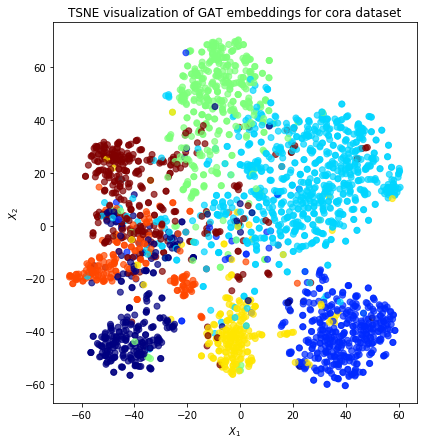

In [36]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for cora dataset".format(transform.__name__)
)
plt.show()